# Environment Set-up

In [ ]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam2.git'

!mkdir -p images
!wget -P images https://raw.githubusercontent.com/facebookresearch/sam2/main/notebooks/images/truck.jpg
!wget -P images https://raw.githubusercontent.com/facebookresearch/sam2/main/notebooks/images/groceries.jpg

!mkdir -p ../checkpoints/
!wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt

PyTorch version: 2.5.0+cu121
Torchvision version: 0.20.0+cu121
CUDA is available: True
  Cloning https://github.com/facebookresearch/sam2.git to /tmp/pip-req-build-yvw4at81
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/sam2.git /tmp/pip-req-build-yvw4at81
  Resolved https://github.com/facebookresearch/sam2.git to commit c2ec8e14a185632b0a5d8b161928ceb50197eddc
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 10.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 7.8 MB/s eta 0:00:00
  Created wheel for SAM-2: filename=SAM_2-1.0-cp310-c

## Load Datasets

In [ ]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
from google.colab import drive
drive.mount('/content/drive')

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True

Mounted at /content/drive
cuda


In [ ]:
# !cd /content/drive/MyDrive/566Data/RGB_Processed/batch1_original/
# !ls

drive  sample_data


### Image Preview Set-up

In [ ]:
np.random.seed(3)

def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

# Example Image and Prediction

In [ ]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)

predictor = SAM2ImagePredictor(sam2_model)
predictor.set_image(image)

In [ ]:
image_path = "/content/drive/MyDrive/566Data/RGB_Processed/batch1_original/HARV_040.tif"
image = Image.open(image_path)
width, height = image.size
print(f"Image resolution: {width} x {height}")

Image resolution: 400 x 400


## Predict by selecting one object

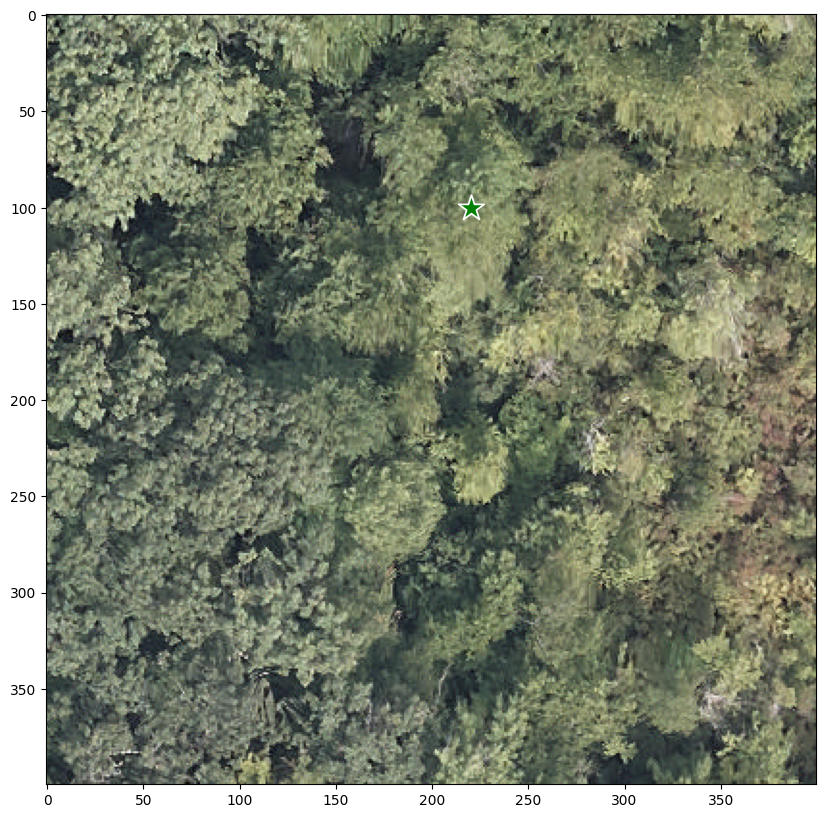

In [ ]:
input_point = np.array([[220, 100]])
input_label = np.array([1])
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

In [ ]:
print(predictor._features["image_embed"].shape, predictor._features["image_embed"][-1].shape)

torch.Size([1, 256, 64, 64]) torch.Size([256, 64, 64])


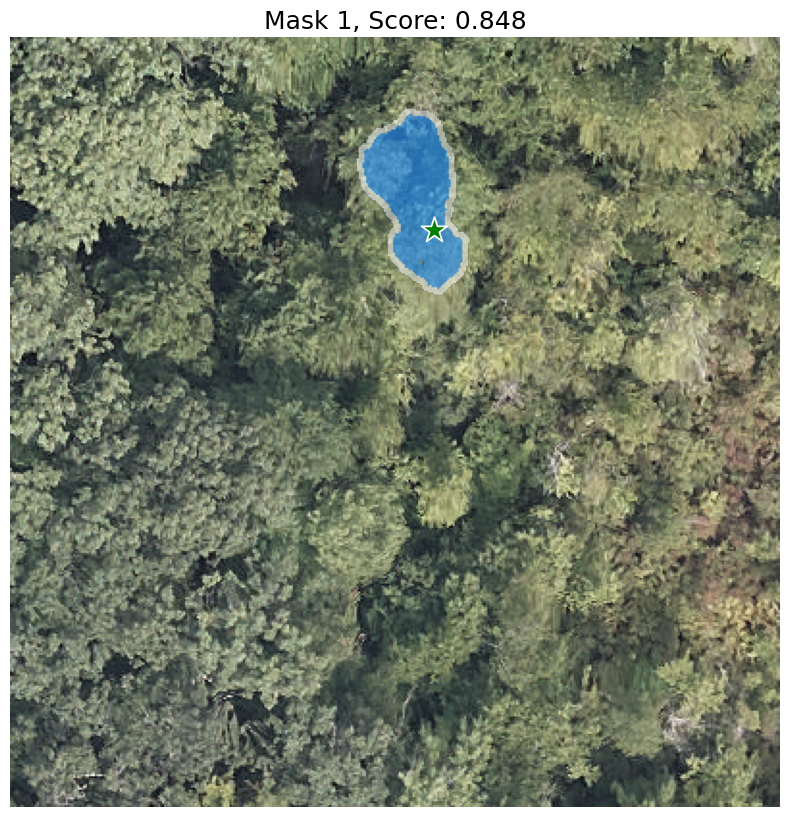

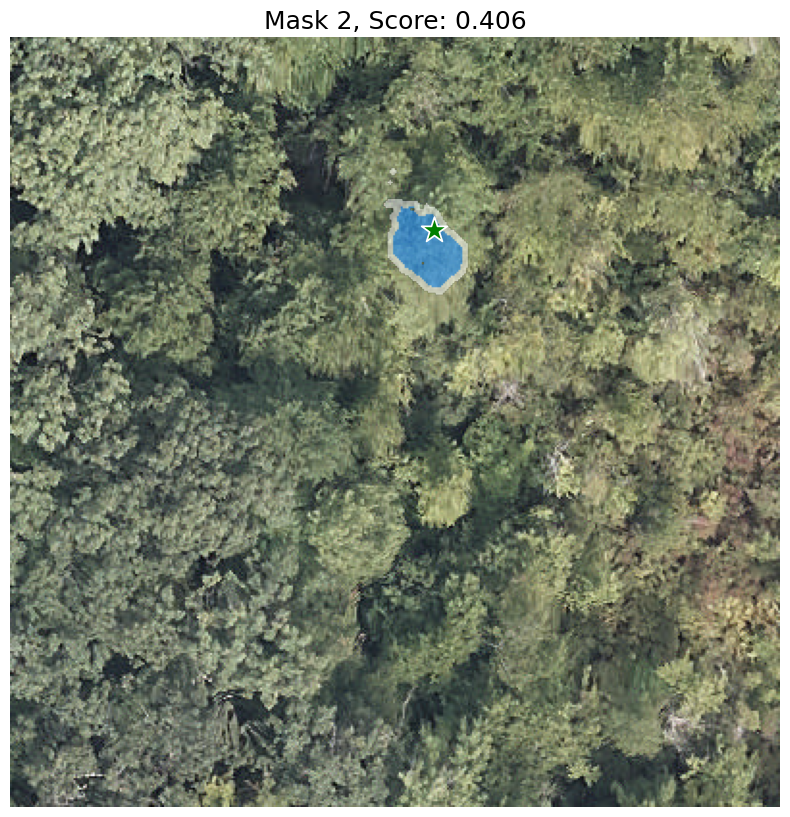

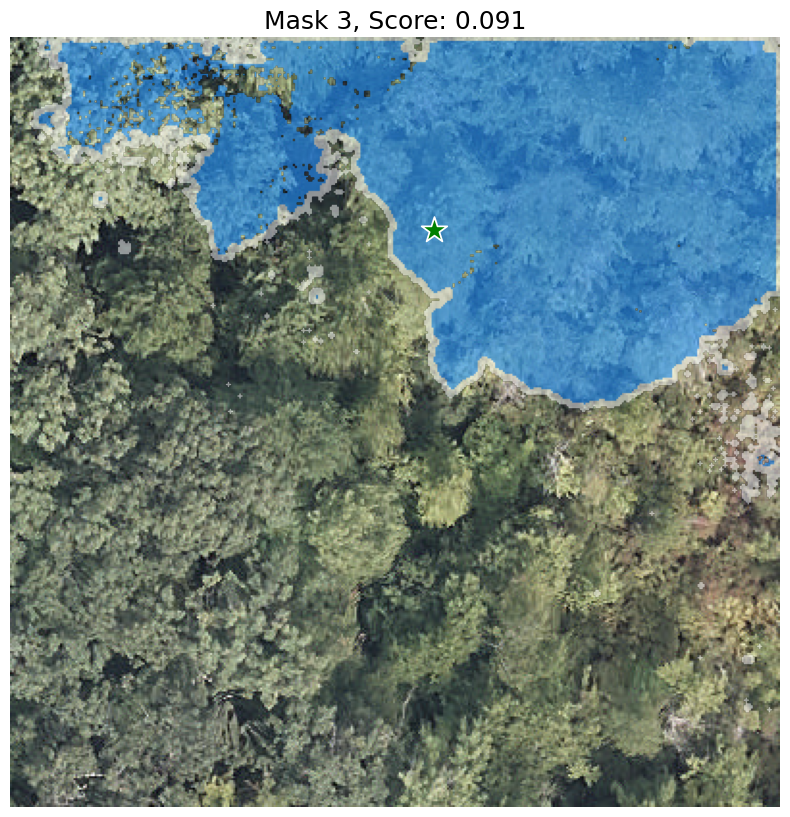

In [ ]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)
sorted_ind = np.argsort(scores)[::-1]
masks = masks[sorted_ind]
scores = scores[sorted_ind]
logits = logits[sorted_ind]
show_masks(image, masks, scores, point_coords=input_point, input_labels=input_label, borders=True)

## Segment Trees by Using Bounding Boxes

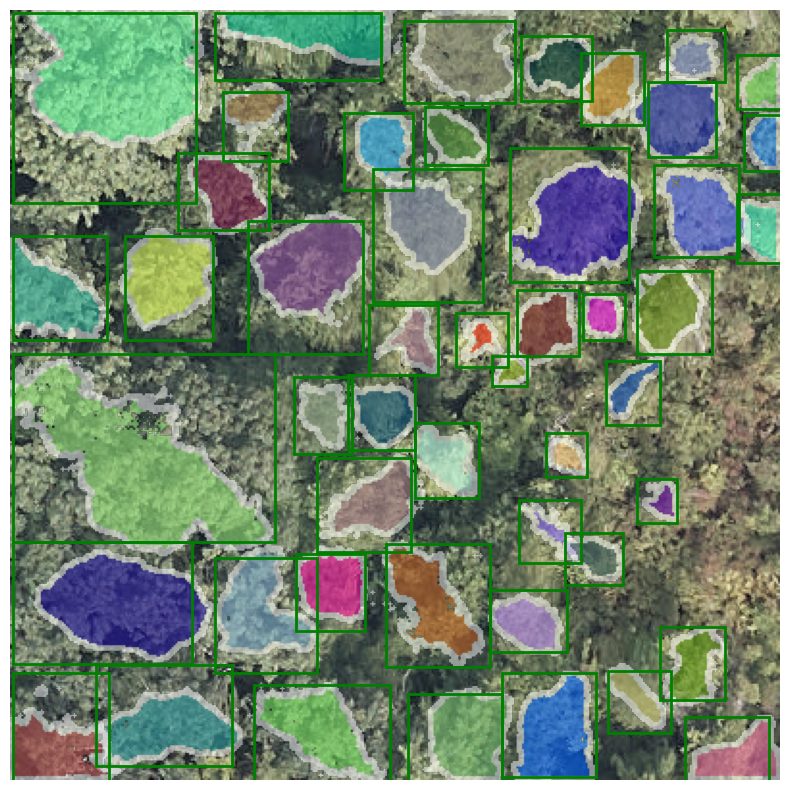

In [ ]:
import xml.etree.ElementTree as ET

def get_bounding_boxes_from_xml(xml_file_path):
  """Parses an XML file containing bounding box annotations and returns a list of bounding boxes as NumPy arrays.

  Args:
    xml_file_path: The path to the XML file.

  Returns:
    A list of NumPy arrays, where each array represents a bounding box in the format [xmin, ymin, xmax, ymax].
  """

  tree = ET.parse(xml_file_path)
  root = tree.getroot()
  bounding_boxes = []

  for obj in root.findall('object'):
    bndbox = obj.find('bndbox')
    xmin = int(bndbox.find('xmin').text)
    ymin = int(bndbox.find('ymin').text)
    xmax = int(bndbox.find('xmax').text)
    ymax = int(bndbox.find('ymax').text)
    bounding_boxes.append([xmin, ymin, xmax, ymax])

  return bounding_boxes

input_boxes_path = "/content/drive/MyDrive/566Data/annotations/HARV_040.xml"  # Replace with your XML file path
bounding_boxes = get_bounding_boxes_from_xml(input_boxes_path)
input_boxes = np.array(bounding_boxes)
masks, scores, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_boxes,
    multimask_output=False,
)

plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.squeeze(0), plt.gca(), random_color=True)
for box in input_boxes:
    show_box(box, plt.gca())
plt.axis('off')
plt.show()


In [ ]:
# In order to evaluate the masks (segmentation), we need to have ground truth masks...

def evaluate_masks(image, predictor, masks, scores, gt_masks, iou_threshold=0.5):
  """Evaluates the predicted masks against ground truth masks using IoU.

  Args:
    image: The input image.
    predictor: The SAM2ImagePredictor object.
    masks: Predicted masks.
    scores: Scores for the predicted masks.
    gt_masks: Ground truth masks.
    iou_threshold: The IoU threshold for considering a mask as a true positive.

  Returns:
    A dictionary containing evaluation metrics:
      - TP: True positives
      - FP: False positives
      - FN: False negatives
      - IoU: Average Intersection over Union
  """
  tp = 0
  fp = 0
  fn = 0
  iou_list = []

  for pred_mask, score in zip(masks, scores):
    best_iou = 0
    matched_gt = False
    for gt_mask in gt_masks:
      intersection = np.logical_and(pred_mask, gt_mask).sum()
      union = np.logical_or(pred_mask, gt_mask).sum()
      if union == 0:
        iou = 0
      else:
        iou = intersection / union

      if iou > best_iou:
        best_iou = iou

      if iou >= iou_threshold:
        matched_gt = True
        break

    if matched_gt:
      tp += 1
      iou_list.append(best_iou)
    else:
      fp += 1

  fn = len(gt_masks) - tp

  if len(iou_list) == 0:
    avg_iou = 0
  else:
    avg_iou = np.mean(iou_list)

  return {"TP": tp, "FP": fp, "FN": fn, "IoU": avg_iou}


# Example usage:
# Assuming you have gt_masks (ground truth masks) defined as a list of NumPy arrays
# You would call the function like this:
# evaluation_results = evaluate_masks(image, predictor, masks, scores, gt_masks)
# print(evaluation_results)
